<a href="https://colab.research.google.com/github/galib96/drug-discovery-ml/blob/main/Bioinformatics_Drug_Discovery_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install chembl-webresource-client

  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.3.1
    Uninstalling PyYAML-5.3.1:
      Successfully uninstalled PyYAML-5.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lazypredict 0.2.9 requires PyYAML==5.3.1, but you have pyyaml 6.0 which is incompatible.


In [3]:
import pandas as pd
import numpy as np

from chembl_webresource_client.new_client import new_client

In [4]:
# target search for Dengue virus

target = new_client.target
target_query = target.search("Dengue virus")
target_df = pd.DataFrame.from_dict(target_query)

target_df

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Dengue virus,Dengue virus,24.00,False,CHEMBL613757,[],ORGANISM,12637
1,[],Dengue virus 1,Dengue virus 1,21.00,False,CHEMBL613360,[],ORGANISM,11053
2,[],Dengue virus 2,Dengue virus 2,21.00,False,CHEMBL613966,[],ORGANISM,11060
3,[],Dengue virus 3,Dengue virus 3,21.00,False,CHEMBL612717,[],ORGANISM,11069
4,[],Dengue virus 4,Dengue virus type 4,18.00,False,CHEMBL613728,[],ORGANISM,11070
...,...,...,...,...,...,...,...,...,...
165,"[{'xref_id': 'P10274', 'xref_name': None, 'xre...",Human T-cell leukemia virus 1 (strain Japan AT...,Human T-cell leukemia virus type I protease,4.00,False,CHEMBL3346,"[{'accession': 'P10274', 'component_descriptio...",SINGLE PROTEIN,11926
166,[],Human immunodeficiency virus type 1 (RF/HAT IS...,Human immunodeficiency virus type 1 (RF/HAT IS...,4.00,False,CHEMBL613498,[],ORGANISM,11701
167,"[{'xref_id': 'Q69422', 'xref_name': None, 'xre...",Hepatitis GB virus B,Hepatitis GB virus B NS5B RNA-dependent RNA po...,4.00,False,CHEMBL5981,"[{'accession': 'Q69422', 'component_descriptio...",SINGLE PROTEIN,39113
168,[],Homo sapiens,Sharpin/RBCK1/RNF31,4.00,False,CHEMBL4296109,"[{'accession': 'Q9H0F6', 'component_descriptio...",PROTEIN COMPLEX,9606


In [5]:
target_df[(target_df['target_type']=='SINGLE PROTEIN') & (target_df['organism']=='Dengue virus')]

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
6,[],Dengue virus,Nonstructural protein 5,14.00,False,CHEMBL4295629,"[{'accession': 'V5TFZ2', 'component_descriptio...",SINGLE PROTEIN,12637


In [6]:
selected_target = target_df.target_chembl_id[6]
selected_target

'CHEMBL4295629'

In [7]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type='IC50')

In [8]:
df = pd.DataFrame.from_dict(res)
df.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,18297472,[],CHEMBL4123978,Inhibition of Dengue virus 4 NS5 full length R...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,0.34
1,None,18297475,[],CHEMBL4123975,Inhibition of Dengue virus 2 NS5 full length R...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,0.36
2,None,18297488,[],CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,5.0
3,None,18297489,[],CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,1.6
4,None,18297490,[],CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,2.0


In [9]:
df.standard_type.unique()

array(['IC50'], dtype=object)

In [10]:
df.to_csv('bioactivity_data_dengue.csv', index=False)

In [11]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [12]:
#!mkdir '/content/gdrive/My Drive/Colab Notebooks/Bioinformatics Project/data'

In [13]:
!cp bioactivity_data_dengue.csv '/content/gdrive/My Drive/Colab Notebooks/Bioinformatics Project/data'

In [14]:
df_clean = df[df['standard_value'].notna()]
df_clean = df_clean[df_clean['canonical_smiles'].notna()]
df_clean.drop_duplicates(['canonical_smiles'], inplace = True)

print(df_clean.shape)
df_clean.head()

(62, 45)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,18297472,[],CHEMBL4123978,Inhibition of Dengue virus 4 NS5 full length R...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,0.34
1,None,18297475,[],CHEMBL4123975,Inhibition of Dengue virus 2 NS5 full length R...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,0.36
2,None,18297488,[],CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,5.0
3,None,18297489,[],CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,1.6
4,None,18297490,[],CHEMBL4123982,Inhibition of Dengue virus RdRp activity using...,B,None,None,BAO_0000190,BAO_0000357,...,Dengue virus,Nonstructural protein 5,12637,None,None,IC50,uM,UO_0000065,None,2.0


In [15]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df_activity = df_clean[selection]

df_activity.head()

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL4126343,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,340.0
1,CHEMBL3417270,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,360.0
2,CHEMBL521487,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,5000.0
3,CHEMBL4127092,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,1600.0
4,CHEMBL4127819,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2000.0


In [16]:
def activity_classifier(sv):

    if float(sv) >= 10000:
        return "inactive"
    elif float(sv) <= 1000:
        return "active"
    else:
        return "intermediate"

In [17]:
df_activity['class'] = df_activity['standard_value'].apply(activity_classifier)

df_activity.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL4126343,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,340.0,active
1,CHEMBL3417270,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,360.0,active
2,CHEMBL521487,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,5000.0,intermediate
3,CHEMBL4127092,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,1600.0,intermediate
4,CHEMBL4127819,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2000.0,intermediate


In [18]:
df_activity.to_csv("bioactivity_dengue_preprocessed_data.csv", index=False)

!cp bioactivity_dengue_preprocessed_data.csv '/content/gdrive/My Drive/Colab Notebooks/Bioinformatics Project/data'

In [19]:
!pip install rdkit-pypi

In [20]:
df_proc = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Bioinformatics Project/data/bioactivity_dengue_preprocessed_data.csv")
df_proc.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL4126343,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,340.00,active
1,CHEMBL3417270,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,360.00,active
2,CHEMBL521487,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,5000.00,intermediate
3,CHEMBL4127092,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,1600.00,intermediate
4,CHEMBL4127819,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2000.00,intermediate


##Lipinski's descriptors

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [21]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [22]:
# calculate descriptors and lipinski values

df_proc['canonical_smiles_mol'] = df_proc['canonical_smiles'].apply(Chem.MolFromSmiles)
df_proc['mol_wt'] = df_proc['canonical_smiles_mol'].apply(Descriptors.MolWt)
df_proc['mol_logp'] = df_proc['canonical_smiles_mol'].apply(Descriptors.MolLogP)
df_proc['num_H_donors'] = df_proc['canonical_smiles_mol'].apply(Lipinski.NumHDonors)
df_proc['num_H_acceptors'] = df_proc['canonical_smiles_mol'].apply(Lipinski.NumHAcceptors)

df_proc.head()

,molecule_chembl_id,canonical_smiles,standard_value,class,canonical_smiles_mol,mol_wt,mol_logp,num_H_donors,num_H_acceptors
0,CHEMBL4126343,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,340.00,active,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb080>,531.20,-1.13,7,14
1,CHEMBL3417270,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,360.00,active,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb030>,524.17,-1.57,7,14
2,CHEMBL521487,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,5000.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb120>,498.17,-2.11,7,12
3,CHEMBL4127092,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,1600.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb170>,508.16,-2.50,7,12
4,CHEMBL4127819,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2000.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb1c0>,522.19,-2.11,7,12


In [23]:
def norm(x):
    """
    to limit the standard value to 100  million
    """
    if x > 100000000:
        x = 100000000
    return x

In [24]:
# restricting the standard value by applying the norm function and log10

df_proc['pIC50'] = np.log10(df_proc['standard_value'].apply(norm))
df_proc.head()

,molecule_chembl_id,canonical_smiles,standard_value,class,canonical_smiles_mol,mol_wt,mol_logp,num_H_donors,num_H_acceptors,pIC50
0,CHEMBL4126343,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,340.00,active,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb080>,531.20,-1.13,7,14,2.53
1,CHEMBL3417270,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,360.00,active,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb030>,524.17,-1.57,7,14,2.56
2,CHEMBL521487,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,5000.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb120>,498.17,-2.11,7,12,3.70
3,CHEMBL4127092,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,1600.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb170>,508.16,-2.50,7,12,3.20
4,CHEMBL4127819,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2000.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb1c0>,522.19,-2.11,7,12,3.30


In [25]:
# getting statistics of pIC50 values

df_proc['pIC50'].describe()

count   62.00
mean     4.16
std      1.05
min      1.20
25%      3.42
50%      4.17
75%      5.13
max      5.66
Name: pIC50, dtype: float64

In [26]:
# dropping the intermediate class

df2 = df_proc[df_proc['class'] != 'intermediate']
df2.head()

,molecule_chembl_id,canonical_smiles,standard_value,class,canonical_smiles_mol,mol_wt,mol_logp,num_H_donors,num_H_acceptors,pIC50
0,CHEMBL4126343,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,340.00,active,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb080>,531.20,-1.13,7,14,2.53
1,CHEMBL3417270,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,360.00,active,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb030>,524.17,-1.57,7,14,2.56
5,CHEMBL486231,C[C@@]1(F)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,18000.00,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb210>,500.16,-1.13,6,11,4.26
6,CHEMBL4127921,C#C[C@@]1(F)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,15900.00,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb260>,510.15,-1.52,6,11,4.20
7,CHEMBL4129313,CC#C[C@@]1(F)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,20000.00,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb2b0>,524.18,-1.13,6,11,4.30


In [27]:
import seaborn as sns
sns.set(style= 'ticks')
import matplotlib.pyplot as plt
%matplotlib inline

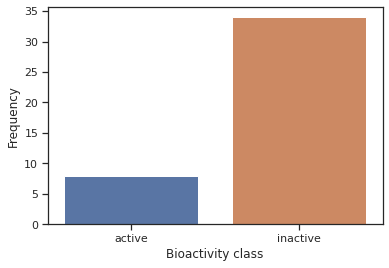

In [28]:
# frequency of Bioactivity class

sns.countplot(x='class', data=df2)

plt.xlabel('Bioactivity class')
plt.ylabel('Frequency')

plt.savefig('plot_bioactivity_class.pdf')

plt.show()

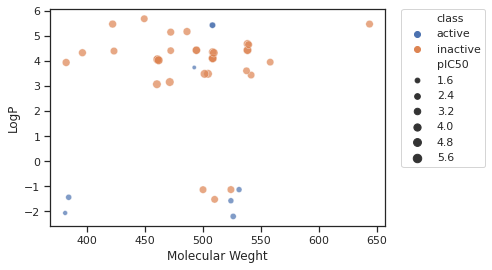

In [29]:
# molecular weight and log of standard P value

sns.scatterplot(x='mol_wt', y='mol_logp', data=df2, hue='class', size='pIC50', alpha = 0.7)

plt.xlabel('Molecular Weght')
plt.ylabel('LogP')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)
plt.savefig('plot_mw_vs_logp.pdf')

plt.show()

### Mann-Whitney U significance test

In [30]:
# Running Mann-Whitney U test for statstically significant difference between classes

from numpy.random import seed, randn
from scipy.stats import mannwhitneyu

seed (1)

def whhitney_test(descriptor, verbose=False):

    """
    function to run mann-whitney U test
    """

    selection = [descriptor, 'class']
    df = df2[selection]
    active = df[df['class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'class']
    df = df2[selection]
    inactive = df[df['class'] == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    stat, p = mannwhitneyu(active, inactive)

    # interpretattion
    alpha = 0.05
    if p > alpha:
        inter = "No significant difference"
    else:
        inter = "Distribution significantly different"

    results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':inter}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

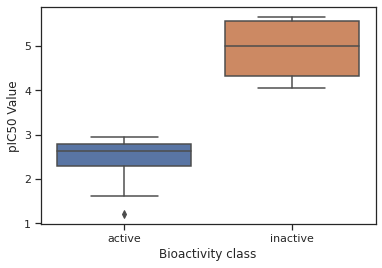

In [31]:
# bioactivity class and pIC50 value

sns.boxplot(x='class', y='pIC50', data=df2)
plt.xlabel('Bioactivity class')
plt.ylabel('pIC50 Value')

plt.savefig('plot_bioactivity_class.pdf')

plt.show()

In [32]:
# whitney test for pIC50
whhitney_test('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.00,0.00,0.05,Distribution significantly different


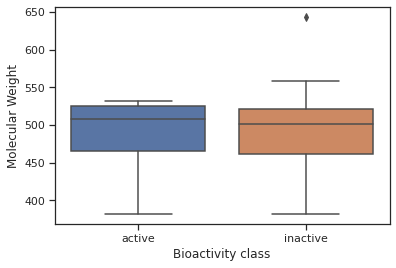

In [33]:
# bioactivity class and molecular weight value

sns.boxplot(x='class', y='mol_wt', data=df2)
plt.xlabel('Bioactivity class')
plt.ylabel('Molecular Weight')

plt.savefig('plot_bioactivity_class.pdf')

plt.show()

In [34]:
# whitney test for pIC50
whhitney_test('mol_wt')

,Descriptor,Statistics,p,alpha,Interpretation
0,mol_wt,130.00,0.43,0.05,No significant difference


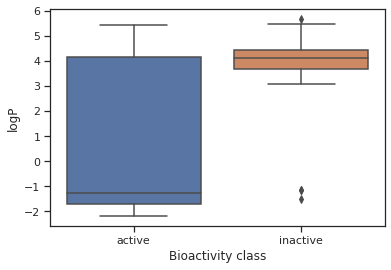

In [35]:
# bioactivity class and log of P value

sns.boxplot(x='class', y='mol_logp', data=df2)
plt.xlabel('Bioactivity class')
plt.ylabel('logP')

plt.savefig('plot_bioactivity_class.pdf')

plt.show()

In [36]:
# whitney test for mol_logP
whhitney_test('mol_logp')

,Descriptor,Statistics,p,alpha,Interpretation
0,mol_logp,74.00,0.02,0.05,Distribution significantly different


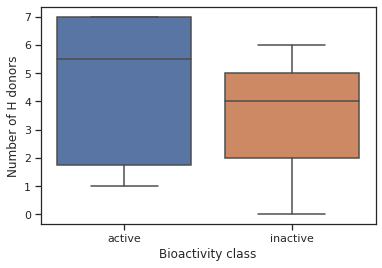

In [37]:
# bioactivity class and num_H_donors

sns.boxplot(x='class', y='num_H_donors', data=df2)
plt.xlabel('Bioactivity class')
plt.ylabel('Number of H donors')

plt.savefig('plot_bioactivity_class.pdf')

plt.show()

In [38]:
# whitney test for num_H_donors
whhitney_test('num_H_donors')

,Descriptor,Statistics,p,alpha,Interpretation
0,num_H_donors,90.50,0.07,0.05,No significant difference


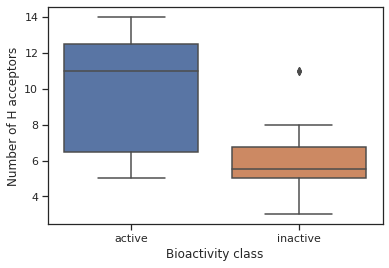

In [39]:
# bioactivity class and num_H_acceptors

sns.boxplot(x='class', y='num_H_acceptors', data=df2)
plt.xlabel('Bioactivity class')
plt.ylabel('Number of H acceptors')

plt.savefig('plot_bioactivity_class.pdf')

plt.show()

In [40]:
# whitney test for number of H acceptors
whhitney_test('num_H_acceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,num_H_acceptors,57.50,0.00,0.05,Distribution significantly different


### Descriptor Claculations

In [41]:
# Package for Descriptor Calculation

! pip install padelpy

In [42]:
df3 = df_proc.copy()

df3.head()

,molecule_chembl_id,canonical_smiles,standard_value,class,canonical_smiles_mol,mol_wt,mol_logp,num_H_donors,num_H_acceptors,pIC50
0,CHEMBL4126343,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,340.00,active,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb080>,531.20,-1.13,7,14,2.53
1,CHEMBL3417270,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,360.00,active,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb030>,524.17,-1.57,7,14,2.56
2,CHEMBL521487,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,5000.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb120>,498.17,-2.11,7,12,3.70
3,CHEMBL4127092,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,1600.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb170>,508.16,-2.50,7,12,3.20
4,CHEMBL4127819,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2000.00,intermediate,<rdkit.Chem.rdchem.Mol object at 0x7f6242eeb1c0>,522.19,-2.11,7,12,3.30


In [43]:
selection = ['canonical_smiles', 'molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index = False, header = False)

df3_selection.head()

,canonical_smiles,molecule_chembl_id
0,N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O...,CHEMBL4126343
1,[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,CHEMBL3417270
2,C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP...,CHEMBL521487
3,C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)...,CHEMBL4127092
4,CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,CHEMBL4127819


In [44]:
! cat molecule.smi | head -5

N#C[C@]1(O)C(n2ccc3c(N)ncnc32)O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@H]1O	CHEMBL4126343
[N-]=[N+]=N[C@]1(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1O	CHEMBL3417270
C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O[C@H]1n1ccc(=O)[nH]c1=O	CHEMBL521487
C#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O[C@H]1n1ccc(=O)[nH]c1=O	CHEMBL4127092
CC#C[C@@]1(O)[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O[C@H]1n1ccc(=O)[nH]c1=O	CHEMBL4127819


In [45]:
! cat molecule.smi | wc -l

62


In [46]:
from padelpy import padeldescriptor

padeldescriptor(mol_dir='/content/molecule.smi', d_file='descriptors.csv', 
                fingerprints=True, removesalt=True, detectaromaticity=True, 
                log=True, retainorder=True)

In [47]:
df3_padel = pd.read_csv('descriptors.csv')
df3_padel

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL4126343,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL3417270,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL521487,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL4127092,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL4127819,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,CHEMBL269277,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,CHEMBL4526128,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,CHEMBL1418094,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,CHEMBL1214186,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df3_padel = df3_padel.drop(columns='Name')
df3_padel.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X_1 = df3_padel.copy()
Y_1 = df3['pIC50']
data_xy = pd.concat([X_1, Y_1], axis=1)
data_xy.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.53
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.56
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.70
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.20
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.30


In [50]:
data_xy.to_csv('data with descriptors padel.csv', index=False)

In [51]:
X = data_xy.drop('pIC50', axis = 1)
Y = data_xy['pIC50']

In [52]:
X.shape

(62, 881)

In [53]:
Y.shape

(62,)

### Model Building

In [54]:
# remove low variance features

from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(0.8*(1-0.8)))
X = selection.fit_transform(X)
X.shape

(62, 186)

In [55]:
# data split into train and test set

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [56]:
x_train.shape, y_train.shape

((49, 186), (49,))

In [57]:
x_test.shape, y_test.shape

((13, 186), (13,))

In [61]:
!pip install lazypredict

  Using cached PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests-cache 0.7.5 requires pyyaml>=5.4, but you have pyyaml 5.3.1 which is incompatible.


In [62]:
from lazypredict.Supervised import LazyRegressor

clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
train, test = clf.fit(x_train, x_test, y_train, y_test)

100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


In [63]:
train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,24504444672710904257829102848509112108058660956...,-3553144477543081245821142408477825905874475975...,71007751113557157421113940864538607263614444206...,0.11
KernelRidge,1.78,-10.27,4.00,0.02
GaussianProcessRegressor,1.69,-9.06,3.78,0.02
DummyRegressor,1.09,-0.27,1.34,0.05
LassoLars,1.09,-0.27,1.34,0.01
Lasso,1.09,-0.27,1.34,0.05
ElasticNet,1.06,0.08,1.14,0.04
LassoLarsIC,1.05,0.33,0.98,0.03
OrthogonalMatchingPursuit,1.03,0.58,0.77,0.03


In [65]:
test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,24504444672710904257829102848509112108058660956...,-3553144477543081245821142408477825905874475975...,71007751113557157421113940864538607263614444206...,0.11
KernelRidge,1.78,-10.27,4.00,0.02
GaussianProcessRegressor,1.69,-9.06,3.78,0.02
DummyRegressor,1.09,-0.27,1.34,0.05
LassoLars,1.09,-0.27,1.34,0.01
Lasso,1.09,-0.27,1.34,0.05
ElasticNet,1.06,0.08,1.14,0.04
LassoLarsIC,1.05,0.33,0.98,0.03
OrthogonalMatchingPursuit,1.03,0.58,0.77,0.03


In [64]:
from sklearn.linear_model import SGDRegressor

np.random.seed(42)

sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)
sgd_model.fit(x_train, y_train)

s1 = sgd_model.score(x_test, y_test)
s1

0.8364099858768093

In [67]:
y_pred = sgd_model.predict(x_test)

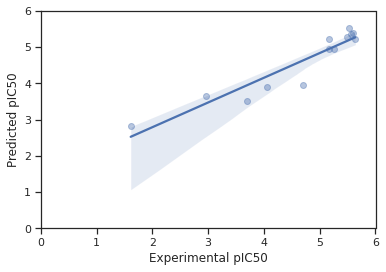

In [68]:
# plotting predicted vs actual data

ax = sns.regplot(y_test, y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50')
ax.set_ylabel('Predicted pIC50')
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

plt.show()